In [1]:
# Train dir
train_result_dir_general = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-10-28/16-43-11_benchmark_train"
# Evaluation dir of general agent
result_dir_general = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-19-50"
# Evaluation dirs of oracle
result_dirs_oracle = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-13-15",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-13-53",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-21-39",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-27-14",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-30-14",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-30-38",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-41-05",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-46-36",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-50-04",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/18-55-35",
]


from rich import print as printr
from rich.progress import track
import pickle
from pathlib import Path
import numpy as np
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional
from pathlib import Path
from experiments.evaluation.utils import recover_traincfg_from_wandb


def load_wandb_table(fn: str | Path) -> pd.DataFrame:
    data = lazy_json_load(fn)
    data = pd.DataFrame(data=np.array(data["data"]), columns=data["columns"])
    return data


def load(folder_eval: str, rpc_fn: str | Path, reload_rpc: bool = False):
    fn_config = ".hydra/config.yaml"
    fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
    fn_wbconfig = "wandb/latest-run/files/config.yaml"
    rpc_fn = Path(rpc_fn)
    if not rpc_fn.is_file():
        reload_rpc = True

    paths = find_multirun_paths(result_dir=folder_eval)

    if reload_rpc:
        rpc_list = []
        for i, p in tqdm(enumerate(paths), total=len(paths)):
            p = Path(p)
            fn_cfg = p / fn_config
            fn_wbsum = p / fn_wbsummary
            fn_wbcfg = p / fn_wbconfig
            if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
                continue
            cfg = OmegaConf.load(fn_cfg)
            traincfg = recover_traincfg_from_wandb(fn_wbcfg)
            summary = lazy_json_load(fn_wbsum)

            if "average_return" in summary:
                average_return = summary["average_return"]
            else:
                average_return = None

            if average_return is None:
                continue

            


            path_to_table = fn_wbsum.parent / summary["return_per_context_table"]["path"]
            return_per_context = load_wandb_table(path_to_table)

            contexts_path = fn_wbsum.parent / summary["evalpost/contexts"]["path"]
            contexts = load_wandb_table(contexts_path)

            visibility = traincfg.wandb.group
            seed = traincfg.seed

            context_ids = return_per_context["context_id"].apply(int).to_list()
            contexts_to_table = pd.DataFrame([contexts.iloc[cidx] for cidx in context_ids])
            for col in contexts_to_table.columns:
                return_per_context[col] = contexts_to_table[col].to_numpy()
            n = len(return_per_context)
            # return_per_context["mode"] = [mode] * n
            # return_per_context["distribution_type"] = [distribution_type] * n
            # return_per_context["average_return"] = [average_return] * n
            return_per_context["seed"] = seed
            return_per_context["visibility"] = visibility

            if cfg.get("contexts_path", None):
                contexts = lazy_json_load(cfg.contexts_path)
                context_id = int(list(contexts.keys())[0])
                return_per_context["context_id"] = context_id

            reps = []
            new_df = []
            for gid, gdf in return_per_context.groupby("context_id"):
                _reps = np.arange(0, len(gdf))
                gdf["rep"] = _reps
                new_df.append(gdf)
            return_per_context = pd.concat(new_df).reset_index(drop=True)
            # return_per_context["rep"] = return_per_context.groupby(["context_id"]).apply(lambda x: )

            rpc_list.append(return_per_context)

            # if i == 10:
            #     break

    if reload_rpc:
        df_rpc = pd.concat(rpc_list)
        df_rpc.to_csv(rpc_fn, index=False)
    else:
        df_rpc = pd.read_csv(rpc_fn)
    
    return df_rpc


reload = True
# from general agent: gather final performance on each context
df_general = load(folder_eval=result_dir_general, rpc_fn="tmp/rpc_general.csv", reload_rpc=reload)
df_general["origin"] = "general"

# from oracles: gather evaluation performance on each context
df_oracle = pd.concat([
    load(
        folder_eval=p, 
        rpc_fn=f"tmp/rpc_oracle_{i}.csv",
        reload_rpc=reload
    ) for i, p in enumerate(result_dirs_oracle)
    ]).reset_index(drop=True)
df_oracle["origin"] = "oracle"

100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


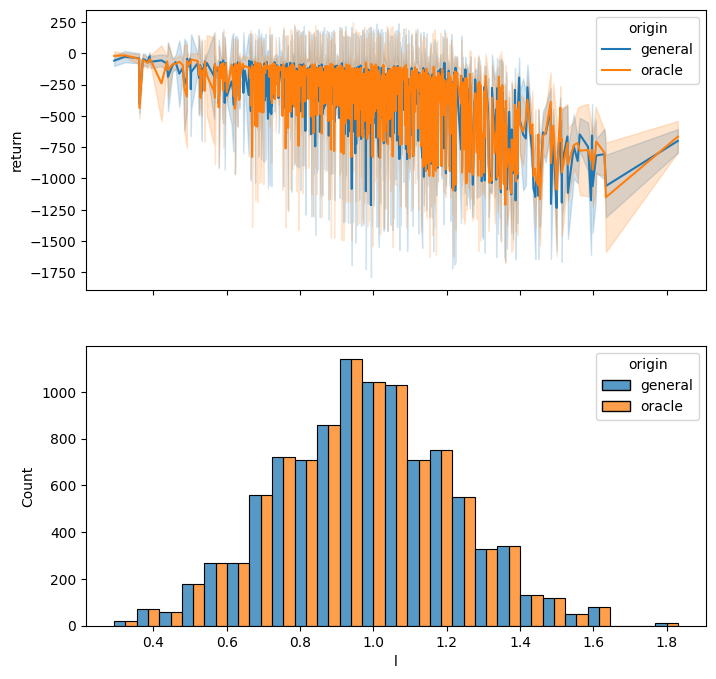

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

n_reps = 10
df = pd.concat([df_general, df_oracle]).reset_index(drop=True)
df = df[df["rep"] < n_reps]

context_feature = "l"

fig = plt.figure(figsize=(8, 8))
axes = fig.subplots(nrows=2, sharex=True)
ax = axes[0]
ax = sns.lineplot(data=df, x=context_feature, y="return", hue="origin", errorbar="sd", ax=ax)

ax = axes[1]
ax = sns.histplot(data=df, x=context_feature, bins=25, hue="origin", ax=ax, multiple="dodge")
plt.show()

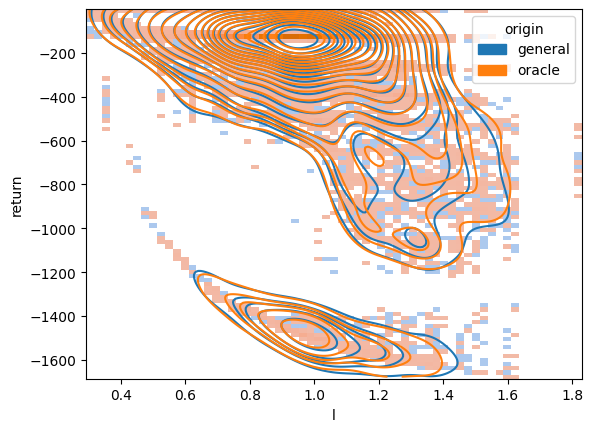

In [37]:
filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
ax = sns.kdeplot(data=filtered_df, x=context_feature, y="return", hue="origin", levels=20, cut=0)
ax = sns.histplot(data=filtered_df, x=context_feature, y="return", hue="origin")

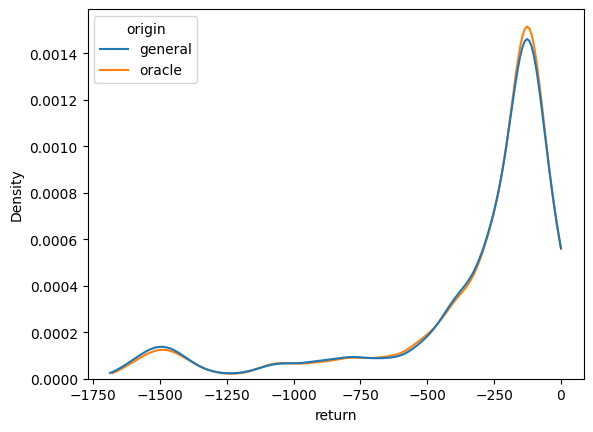

In [33]:
filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
ax = sns.kdeplot(data=filtered_df, x="return", hue="origin", levels=20, cut=0)

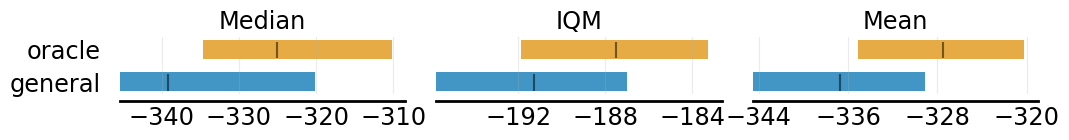

In [18]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
reps = 10000
xlabel = ""

metric_names = ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  # metrics.aggregate_optimality_gap(x)
  ])


# Create score matrix
# Scores: (num_points x num_tasks), here:
#         (num_seeds * num_reps x num_tasks)
# Pendulum: num_tasks = n_contexts = 100
score_dict = {}
for group_id, group_df in filtered_df.groupby("origin"):
  n_seeds = group_df["seed"].nunique()
  n_context_ids = group_df["context_id"].nunique()
  scores = np.zeros((n_seeds * n_reps, n_context_ids))
  for i, ((seed, rep), gdf) in enumerate(group_df.groupby(["seed", "rep"])):
    R = gdf["return"]
    n = len(gdf)
    index = (seed - 1) * n_seeds + rep  # seed is 1-based
    scores[i] = R
  score_dict[group_id] = scores


aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)


fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=metric_names,
    algorithms=list(score_dict.keys()), xlabel=xlabel)
# fig.set_tight_layout(True)
plt.show()

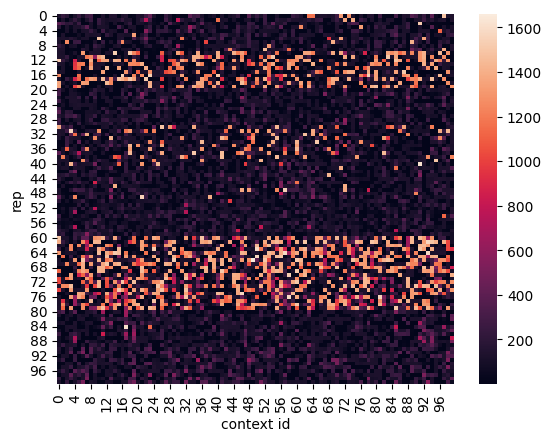

In [19]:
gap = np.abs(score_dict["oracle"] - score_dict["general"])
df_gap = pd.DataFrame(gap)

ax = sns.heatmap(data=gap)
ax.set_xlabel("context id")
ax.set_ylabel("rep")
plt.show()